<a href="https://colab.research.google.com/github/m-richa/Co-domain-adaptation-for-image-classification/blob/main/codomain_adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git remote add origin https://<USERNAME>:<PASSWORD>@github.com/<USERNAME>/reponame.git

In [ ]:
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Flatten, Input
import tensorflow_datasets as tfds
from tensorflow.python.keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q photo.zip
!unzip -q sketch.zip

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
src_path_train = '/content/photo/'
trg_path = '/content/sketch/'

In [ ]:
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import numpy as np
import os


class MergedGenerators(Sequence):

    def __init__(self, batch_size, generators=[], sub_batch_size=[]):
        self.generators = generators
        self.sub_batch_size = sub_batch_size
        self.batch_size = batch_size

    def __len__(self):
        return int(
            sum([(len(self.generators[idx]) * self.sub_batch_size[idx])
                 for idx in range(len(self.sub_batch_size))]) /
            self.batch_size)

    def __getitem__(self, index):
        """Getting items from the generators and packing them"""

        X_batch = []
        Y_batch = []
        for generator in self.generators:
            if generator.class_mode is None:
                x1 = generator[index % len(generator)]
                X_batch = [*X_batch, *x1]

            else:
                x1, y1 = generator[index % len(generator)]
                X_batch = [*X_batch, *x1]
                Y_batch = [*Y_batch, *y1]

        if self.generators[0].class_mode is None:
            return np.array(X_batch)
        return np.array(X_batch), np.array(Y_batch)


def build_datagenerator(dir1=None, dir2=None, batch_size=32):
    n_images_in_dir1 = sum([len(files) for r, d, files in os.walk(dir1)])
    n_images_in_dir2 = sum([len(files) for r, d, files in os.walk(dir2)])

    # Have to set different batch size for two generators as number of images
    # in those two directories are not same. As we have to equalize the image
    # share in the generators
    generator1_batch_size = int((n_images_in_dir1 * batch_size) /
                                (n_images_in_dir1 + n_images_in_dir2))

    generator2_batch_size = batch_size - generator1_batch_size

    generator1 = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=5.,
        horizontal_flip=True,
    )

    generator2 = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=5.,
        horizontal_flip=True,
    )

    # generator2 has different image augmentation attributes than generaor1
    generator1 = generator1.flow_from_directory(
        dir1,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=generator1_batch_size,
        shuffle=True,
        seed=4,
        interpolation="bicubic",
    )

    generator2 = generator2.flow_from_directory(
        dir2,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        class_mode=None,
        batch_size=generator2_batch_size,
        shuffle=True,
        seed=4,
        interpolation="bicubic",
    )

    return MergedGenerators(
        batch_size,
        generators=[generator1, generator2],
        sub_batch_size=[generator1_batch_size, generator2_batch_size])


def train_datagen(batch_size=BATCH_SIZE):
    datagen = build_datagenerator(dir1=src_path_train,
                                  dir2=trg_path,
                                  batch_size=batch_size)

    print("Datagenerator length (Batch count):", len(datagen))

    for batch_count, image_batch in enumerate(datagen):
        if batch_count == 1:
            break

        image_batch = np.array(image_batch)
        #print(image_batch[0][1].shape)

        #print("Images: ", image_batch.shape)

        plt.figure(figsize=(10, 10))
        for i in range(image_batch[0].shape[0]):
            plt.subplot(1, batch_size, i + 1)
            plt.imshow(image_batch[0][i], interpolation='nearest')
            plt.axis('off')
            plt.tight_layout()

    return datagen




In [ ]:
train_data_gen.__getitem__(1)[0][:2].shape

(2, 224, 224, 3)

In [ ]:
class model(tf.keras.Model):

    def __init__(self, num_classes=7):
        super(model, self).__init__()

        self.input_layer = tf.keras.layers.Input(name="inp_img", shape=(224,224,3,))
        self.feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224,224,3,),
                                               include_top=False,
                                               weights='imagenet')
        self.feature_extractor.trainable=False
        self.l1 = tf.keras.layers.GlobalAveragePooling2D()
        self.l2 = tf.keras.layers.Flatten()
        self.l3 = tf.keras.layers.Dense(1024, activation="relu")
        self.l4 = tf.keras.layers.Dense(512, activation="relu")
        self.l5 =tf.keras.layers.Dense(7, activation="softmax", name="logits")

        #super(model, self).__init__(inputs=self.input_layer ,outputs=self.l5,)
    
    def summary(self):
        x = self.input_layer
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

    def call(self, inputs):
        x = self.feature_extractor(inputs)
        x.trainable = False

        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)

        return x

if __name__ == '__main__':
    model = model()
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 26,214,279
Trainable params: 2,626,567
Non-trainable params: 23,587,712
_________________________________________________________________


94773248/94765736 [==============================] - 1s 0us/step


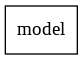

In [ ]:
def weighted_cross_entropy_loss(logits):
    logit_max = K.max(logits, 1)
    y_true = K.argmax(logits)
    
    is_condition = logit_max>=0.95
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(y_true, logits)
    weighted_loss = tf.multiply(logit_max, loss)
    return tf.where(is_condition, weighted_loss, 0)

In [ ]:
for epoch in range(EPOCHS):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = final_model(x_batch_train[0])
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))

In [ ]:
def loss_object(logits, labels):
  loss1 = tf.keras.losses.categorical_crossentropy(labels, logits[:14])
  loss2 = weighted_cross_entropy_loss(logits[14:])

  return loss1, loss2

In [ ]:
train_data_gen =train_datagen(50)

Found 1670 images belonging to 7 classes.
Found 3929 images belonging to 7 classes.
Datagenerator length (Batch count): 112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:


def train_steps(train_data):
  for i in range(5):
    img_src = train_data_gen.__getitem__(i)[0]#[:10]
    src_label = train_data_gen.__getitem__(i)[1]
    print(train_data_gen.__getitem__(i)[0].shape)
    print(train_data_gen.__getitem__(i)[1].shape)

    with tf.GradientTape() as tape:
      logits = model(img_src, training=True)
      loss_value1, loss_value2 = loss_object(logits, src_label)

    print(logits.numpy())
    print(loss_value1.numpy())
    print(loss_value2.numpy())
    break


In [ ]:
train_steps(train_data_gen)

(50, 224, 224, 3)
(14, 7)
[[0.12817967 0.26491904 0.06202437 0.13155836 0.1774022  0.04456371
  0.19135273]
 [0.12125965 0.27804053 0.05968409 0.13218895 0.17972888 0.04330906
  0.18578881]
 [0.12258556 0.2758477  0.06119408 0.13103262 0.17882416 0.04352858
  0.18698725]
 [0.11671048 0.28475344 0.05687701 0.13341163 0.17867918 0.04287066
  0.18669756]
 [0.12721507 0.2749538  0.06427386 0.13331972 0.1792745  0.04330884
  0.17765422]
 [0.12318549 0.27662414 0.05891582 0.13484283 0.17935632 0.04236877
  0.18470664]
 [0.12218942 0.2727019  0.05707665 0.13353206 0.17737924 0.0436166
  0.1935042 ]
 [0.12161645 0.26831278 0.06177183 0.1300962  0.18333259 0.04516643
  0.18970376]
 [0.12298767 0.2741636  0.05798587 0.13289833 0.17898938 0.04324796
  0.18972717]
 [0.12691316 0.27675912 0.06000006 0.13451399 0.17730992 0.04270194
  0.18180184]
 [0.12896097 0.2849133  0.06001814 0.12686066 0.19391017 0.03928415
  0.1660526 ]
 [0.12609693 0.26478627 0.06205224 0.13359573 0.17971073 0.04491132
  0.1